In [1]:
import os
import boto3
import sagemaker
import s3fs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import time
import json
import sagemaker.amazon.common as smac

role = sagemaker.get_execution_role()
sess = sagemaker.Session()

bucket = sess.default_bucket()
prefix = "marcus-machine-failure"

## Load training data


In [2]:
import s3fs

s3 = s3fs.S3FileSystem(anon=False)

key = "ai4i2020_prep.csv"
with s3.open(f'{bucket}/{prefix}/{key}','r') as f:
    feature_df = pd.read_csv(f)

In [3]:
feature_df.tail()

,y,air_temperature,process_temperature,rotational_speed,torque,tool_wear,high,low,medium
19317,1,0.565180,0.518519,0.132712,0.578316,0.830040,1,0,0
19318,1,0.338743,0.356003,0.878347,0.094848,0.335968,0,0,1
19319,1,0.462273,0.655407,0.319558,0.330801,0.873518,0,0,0
19320,1,0.647715,0.594625,0.302678,0.366137,0.893281,0,0,1
19321,1,0.730462,0.598804,0.116997,0.590625,0.280632,0,0,1


Adapted from SageMaker example [Breast Cancer Prediction](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_applying_machine_learning/breast_cancer_prediction/Breast%20Cancer%20Prediction.html) notebook

# Create Features and Labels

## Split the data into 80% training, 10% validation and 10% testing.

In [4]:
rand_split = np.random.rand(len(feature_df))
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.9

data_train = feature_df[train_list]
data_val = feature_df[val_list]
data_test = feature_df[test_list]

train_y = ((data_train.iloc[:, 0] == 1) + 0).to_numpy()
train_X = data_train.iloc[:, 1:].to_numpy()

val_y = ((data_val.iloc[:, 0] == 1) + 0).to_numpy()
val_X = data_val.iloc[:, 1:].to_numpy()

test_y = ((data_test.iloc[:, 0] == 0) + 0).to_numpy()
test_X = data_test.iloc[:, 1:].to_numpy();

Now, we’ll convert the datasets to the recordIO-wrapped protobuf format used by the Amazon SageMaker algorithms, and then upload this data to S3.   We’ll start with training data.

In [5]:
train_file = "linear_train.data"

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, train_X.astype("float32"), train_y.astype("float32"))
f.seek(0)

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train", train_file)
).upload_fileobj(f)

Next we’ll convert and upload the validation dataset.

In [6]:
validation_file = "linear_validation.data"

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, val_X.astype("float32"), val_y.astype("float32"))
f.seek(0)

boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "validation", validation_file)
).upload_fileobj(f)

## Training the linear model
Once we have the data preprocessed and available in the correct format for training, the next step is to actually train the model using the data. Since this data is relatively small, it isn't meant to show off the performance of the Linear Learner training algorithm, although we have tested it on multi-terabyte datasets.

Again, we'll use the Amazon SageMaker Python SDK to kick off training, and monitor status until it is completed. In this example that takes between 7 and 11 minutes. Despite the dataset being small, provisioning hardware and loading the algorithm container take time upfront.

First, let's specify our containers. Since we want this notebook to run in all 4 of Amazon SageMaker's regions, we'll create a small lookup. More details on algorithm containers can be found in AWS documentation.

In [7]:
from sagemaker import image_uris

container = image_uris.retrieve(region=boto3.Session().region_name, framework="linear-learner")

In [8]:
linear_job = "BASELINE-linear-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", linear_job)

linear_training_params = {
    "RoleArn": role,
    "TrainingJobName": linear_job,
    "AlgorithmSpecification": {"TrainingImage": container, "TrainingInputMode": "File"},
    "ResourceConfig": {"InstanceCount": 1, "InstanceType": "ml.c4.2xlarge", "VolumeSizeInGB": 10},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix),
                    "S3DataDistributionType": "ShardedByS3Key",
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/".format(bucket, prefix)},
    "HyperParameters": {
        "feature_dim": "8",
        "mini_batch_size": "100",
        "predictor_type": "regressor",
        "epochs": "10",
        "num_models": "32",
        "loss": "absolute_loss",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 60 * 60},
}

Job name is: BASELINE-linear-2021-07-20-17-38-30


Now let’s kick off our training job in SageMaker’s distributed, managed training, using the parameters we just created. Because training is managed, we don’t have to wait for our job to finish to continue, but for this case, let’s use boto3’s ‘training_job_completed_or_stopped’ waiter so we can ensure that the job has been started.

In [ ]:
%%time

region = boto3.Session().region_name
sm = boto3.client("sagemaker")

sm.create_training_job(**linear_training_params)

status = sm.describe_training_job(TrainingJobName=linear_job)["TrainingJobStatus"]
print(status)
sm.get_waiter("training_job_completed_or_stopped").wait(TrainingJobName=linear_job)
if status == "Failed":
    message = sm.describe_training_job(TrainingJobName=linear_job)["FailureReason"]
    print("Training failed with the following error: {}".format(message))
    raise Exception("Training job failed")

InProgress
CPU times: user 145 ms, sys: 12.6 ms, total: 157 ms
Wall time: 6min


## Host

Now that we’ve trained the linear algorithm on our data, let’s setup a model which can later be hosted. We will: 1. Point to the scoring container 1. Point to the model.tar.gz that came from training 1. Create the hosting model

In [ ]:
linear_hosting_container = {
    "Image": container,
    "ModelDataUrl": sm.describe_training_job(TrainingJobName=linear_job)["ModelArtifacts"][
        "S3ModelArtifacts"
    ],
}

create_model_response = sm.create_model(
    ModelName=linear_job, ExecutionRoleArn=role, PrimaryContainer=linear_hosting_container
)

print(create_model_response["ModelArn"])

arn:aws:sagemaker:us-east-1:405147176623:model/baseline-linear-2021-07-20-17-38-30


Once we’ve setup a model, we can configure what our hosting endpoints should be. Here we specify: 1. EC2 instance type to use for hosting 1. Initial number of instances 1. Our hosting model name

In [ ]:
linear_endpoint_config = "VALIDATION-linear-endpoint-config-" + time.strftime(
    "%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(linear_endpoint_config)
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=linear_endpoint_config,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialInstanceCount": 1,
            "ModelName": linear_job,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

VALIDATION-linear-endpoint-config-2021-07-20-17-44-31
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:405147176623:endpoint-config/validation-linear-endpoint-config-2021-07-20-17-44-31


Now that we’ve specified how our endpoint should be configured, we can create them. This can be done in the background, but for now let’s run a loop that updates us on the status of the endpoints so that we know when they are ready for use.

In [ ]:
%%time

linear_endpoint = "VALIDATION-linear-endpoint-" + time.strftime("%Y%m%d%H%M", time.gmtime())
print(linear_endpoint)
create_endpoint_response = sm.create_endpoint(
    EndpointName=linear_endpoint, EndpointConfigName=linear_endpoint_config
)
print(create_endpoint_response["EndpointArn"])

resp = sm.describe_endpoint(EndpointName=linear_endpoint)
status = resp["EndpointStatus"]
print("Status: " + status)

sm.get_waiter("endpoint_in_service").wait(EndpointName=linear_endpoint)

resp = sm.describe_endpoint(EndpointName=linear_endpoint)
status = resp["EndpointStatus"]
print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

if status != "InService":
    raise Exception("Endpoint creation did not succeed")

VALIDATION-linear-endpoint-202107201744
arn:aws:sagemaker:us-east-1:405147176623:endpoint/validation-linear-endpoint-202107201744
Status: Creating


## Predict

Now that we have our hosted endpoint, we can generate statistical predictions from it. Let’s predict on our test dataset to understand how accurate our model is.

There are many metrics to measure classification accuracy. Common examples include include: - Precision - Recall - F1 measure - Area under the ROC curve - AUC - Total Classification Accuracy - Mean Absolute Error

For our example, we’ll keep things simple and use total classification accuracy as our metric of choice. We will also evaluate Mean Absolute Error (MAE) as the linear-learner has been optimized using this metric, not necessarily because it is a relevant metric from an application point of view. We’ll compare the performance of the linear-learner against a naive benchmark prediction which uses majority class observed in the training data set for prediction on the test data.

In [21]:
def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=",", fmt="%g")
    return csv.getvalue().decode().rstrip()

Next, we’ll invoke the endpoint to get predictions.

In [22]:
runtime = boto3.client("runtime.sagemaker")

payload = np2csv(test_X)
response = runtime.invoke_endpoint(
    EndpointName=linear_endpoint, ContentType="text/csv", Body=payload
)
result = json.loads(response["Body"].read().decode())
test_pred = np.array([r["score"] for r in result["predictions"]])

Let’s compare linear learner based mean absolute prediction errors from a baseline prediction which uses majority class to predict every instance.

In [23]:
test_mae_linear = np.mean(np.abs(test_y - test_pred))
test_mae_baseline = np.mean(
    np.abs(test_y - np.median(train_y))
)  ## training median as baseline predictor

print("Test MAE Baseline :", round(test_mae_baseline, 3))
print("Test MAE Linear:", round(test_mae_linear, 3))

Test MAE Baseline : 0.511
Test MAE Linear: 0.8


Let’s compare predictive accuracy using a classification threshold of 0.5 for the predicted and compare against the majority class prediction from training data set.

In [24]:
test_pred_class = (test_pred > 0.5) + 0
test_pred_baseline = np.repeat(np.median(train_y), len(test_y))

prediction_accuracy = np.mean((test_y == test_pred_class)) * 100
baseline_accuracy = np.mean((test_y == test_pred_baseline)) * 100

print("Prediction Accuracy:", round(prediction_accuracy, 1), "%")
print("Baseline Accuracy:", round(baseline_accuracy, 1), "%")

Prediction Accuracy: 15.1 %
Baseline Accuracy: 48.9 %


In [25]:
test_y = test_y.astype(float)

In [26]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_y, test_pred_class, normalize=True)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.15


In [27]:
from sklearn.metrics import precision_recall_fscore_support
(precision, recall, fbeta, support) = precision_recall_fscore_support(test_y, test_pred_class, average='binary')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F-Beta: {fbeta:.2f}')
print(f'Support: {support}')
    

Precision: 0.19
Recall: 0.24
F-Beta: 0.21
Support: None


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support

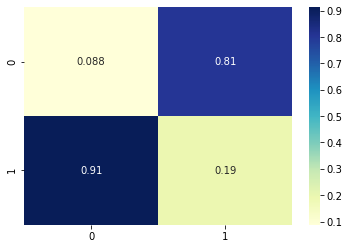

In [29]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
import seaborn as sns

_ = sns.heatmap(confusion_matrix(test_y, test_pred_class, normalize='pred'), annot=True, cmap="YlGnBu")

## Cleanup

In [30]:
sm.delete_endpoint(EndpointName=linear_endpoint)

{'ResponseMetadata': {'RequestId': '737f6f1e-e638-4cca-8a62-cbe202a64afe',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '737f6f1e-e638-4cca-8a62-cbe202a64afe',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 20 Jul 2021 17:55:47 GMT'},
  'RetryAttempts': 0}}